In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMClassifier
import warnings, gc, string, random
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff

init_notebook_mode(connected=True)
color=px.colors.qualitative.Plotly
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))

train=pd.read_csv('../input/tabular-playground-series-may-2022/train.csv', index_col='id')
test=pd.read_csv('../input/tabular-playground-series-may-2022/test.csv', index_col='id')
sub=pd.read_csv('../input/tabular-playground-series-may-2022/sample_submission.csv')

print("Train Shape: There are {:,.0f} rows and {:,.0f} columns.\nMissing values = {}, Duplicates = {}.\n".
      format(train.shape[0], train.shape[1],train.isna().sum().sum(), train.duplicated().sum()))
print("Test Shape: There are {:,.0f} rows and {:,.0f} columns.\nMissing values = {}, Duplicates = {}.\n".
      format(test.shape[0], test.shape[1], test.isna().sum().sum(), test.duplicated().sum()))
df=train.describe()
display(df.style.format('{:,.3f}')
        .background_gradient(subset=(df.index[1:],df.columns[:]), cmap='GnBu'))


Train Shape: There are 800,000 rows and 32 columns.
Missing values = 0, Duplicates = 0.

Test Shape: There are 100,000 rows and 31 columns.
Missing values = 0, Duplicates = 0.



,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
count,"800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000","800,000.000"
mean,-0.000,0.001,0.001,-0.002,-0.001,0.001,-0.000,2.032,2.059,2.363,2.178,1.804,2.842,2.240,1.516,2.102,2.097,1.859,2.065,0.309,-0.179,-0.158,-0.009,-0.369,-0.344,0.178,0.357,-0.343,0.346,1.003,0.486
std,0.999,0.999,1.001,1.000,1.000,1.000,1.000,1.657,1.592,1.638,1.646,1.538,1.763,1.538,1.360,1.569,1.560,1.468,1.565,2.316,2.401,2.485,2.451,2.453,2.388,2.417,2.477,238.670,0.476,0.819,0.500
min,-4.600,-4.674,-4.643,-4.659,-4.749,-4.750,-4.843,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-10.912,-11.258,-13.310,-11.854,-12.301,-11.416,-11.831,-14.301,"-1,229.753",0.000,0.000,0.000
25%,-0.676,-0.675,-0.674,-0.676,-0.676,-0.672,-0.674,1.000,1.000,1.000,1.000,1.000,2.000,1.000,0.000,1.000,1.000,1.000,1.000,-1.236,-1.806,-1.823,-1.645,-2.019,-1.957,-1.440,-1.261,-159.306,0.000,0.000,0.000
50%,0.001,0.003,0.003,-0.003,-0.002,0.000,-0.001,2.000,2.000,2.000,2.000,2.000,3.000,2.000,1.000,2.000,2.000,2.000,2.000,0.330,-0.191,-0.155,0.031,-0.390,-0.342,0.162,0.405,-0.491,0.000,1.000,0.000
75%,0.674,0.675,0.678,0.672,0.674,0.676,0.675,3.000,3.000,3.000,3.000,3.000,4.000,3.000,2.000,3.000,3.000,3.000,3.000,1.881,1.445,1.506,1.662,1.256,1.266,1.798,2.028,158.931,1.000,2.000,1.000
max,4.749,4.816,4.962,4.455,4.949,4.972,4.823,15.000,16.000,14.000,14.000,13.000,14.000,12.000,14.000,14.000,15.000,14.000,13.000,12.080,11.475,11.679,11.344,12.247,12.390,12.529,12.913,"1,229.563",1.000,2.000,1.000


In [3]:
target=train.target.value_counts(normalize=True)[::-1]
text=['State {}'.format(i) for i in target.index]
color,pal=['#38A6A5','#E1B580'],['#88CAC9','#EDD3B3']
if text[0]=='State 0':
    color,pal=color,pal
else:
    color,pal=color[::-1],pal[::-1]
fig=go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.5, 
                     text=text, sort=False, showlegend=False,
                     marker=dict(colors=pal,line=dict(color=color,width=2)),
                     hovertemplate = "State %{label}: %{value:.2f}%"))
fig.update_layout(template=temp, title='Target Distribution', 
                  uniformtext_minsize=15, uniformtext_mode='hide')
fig.show()


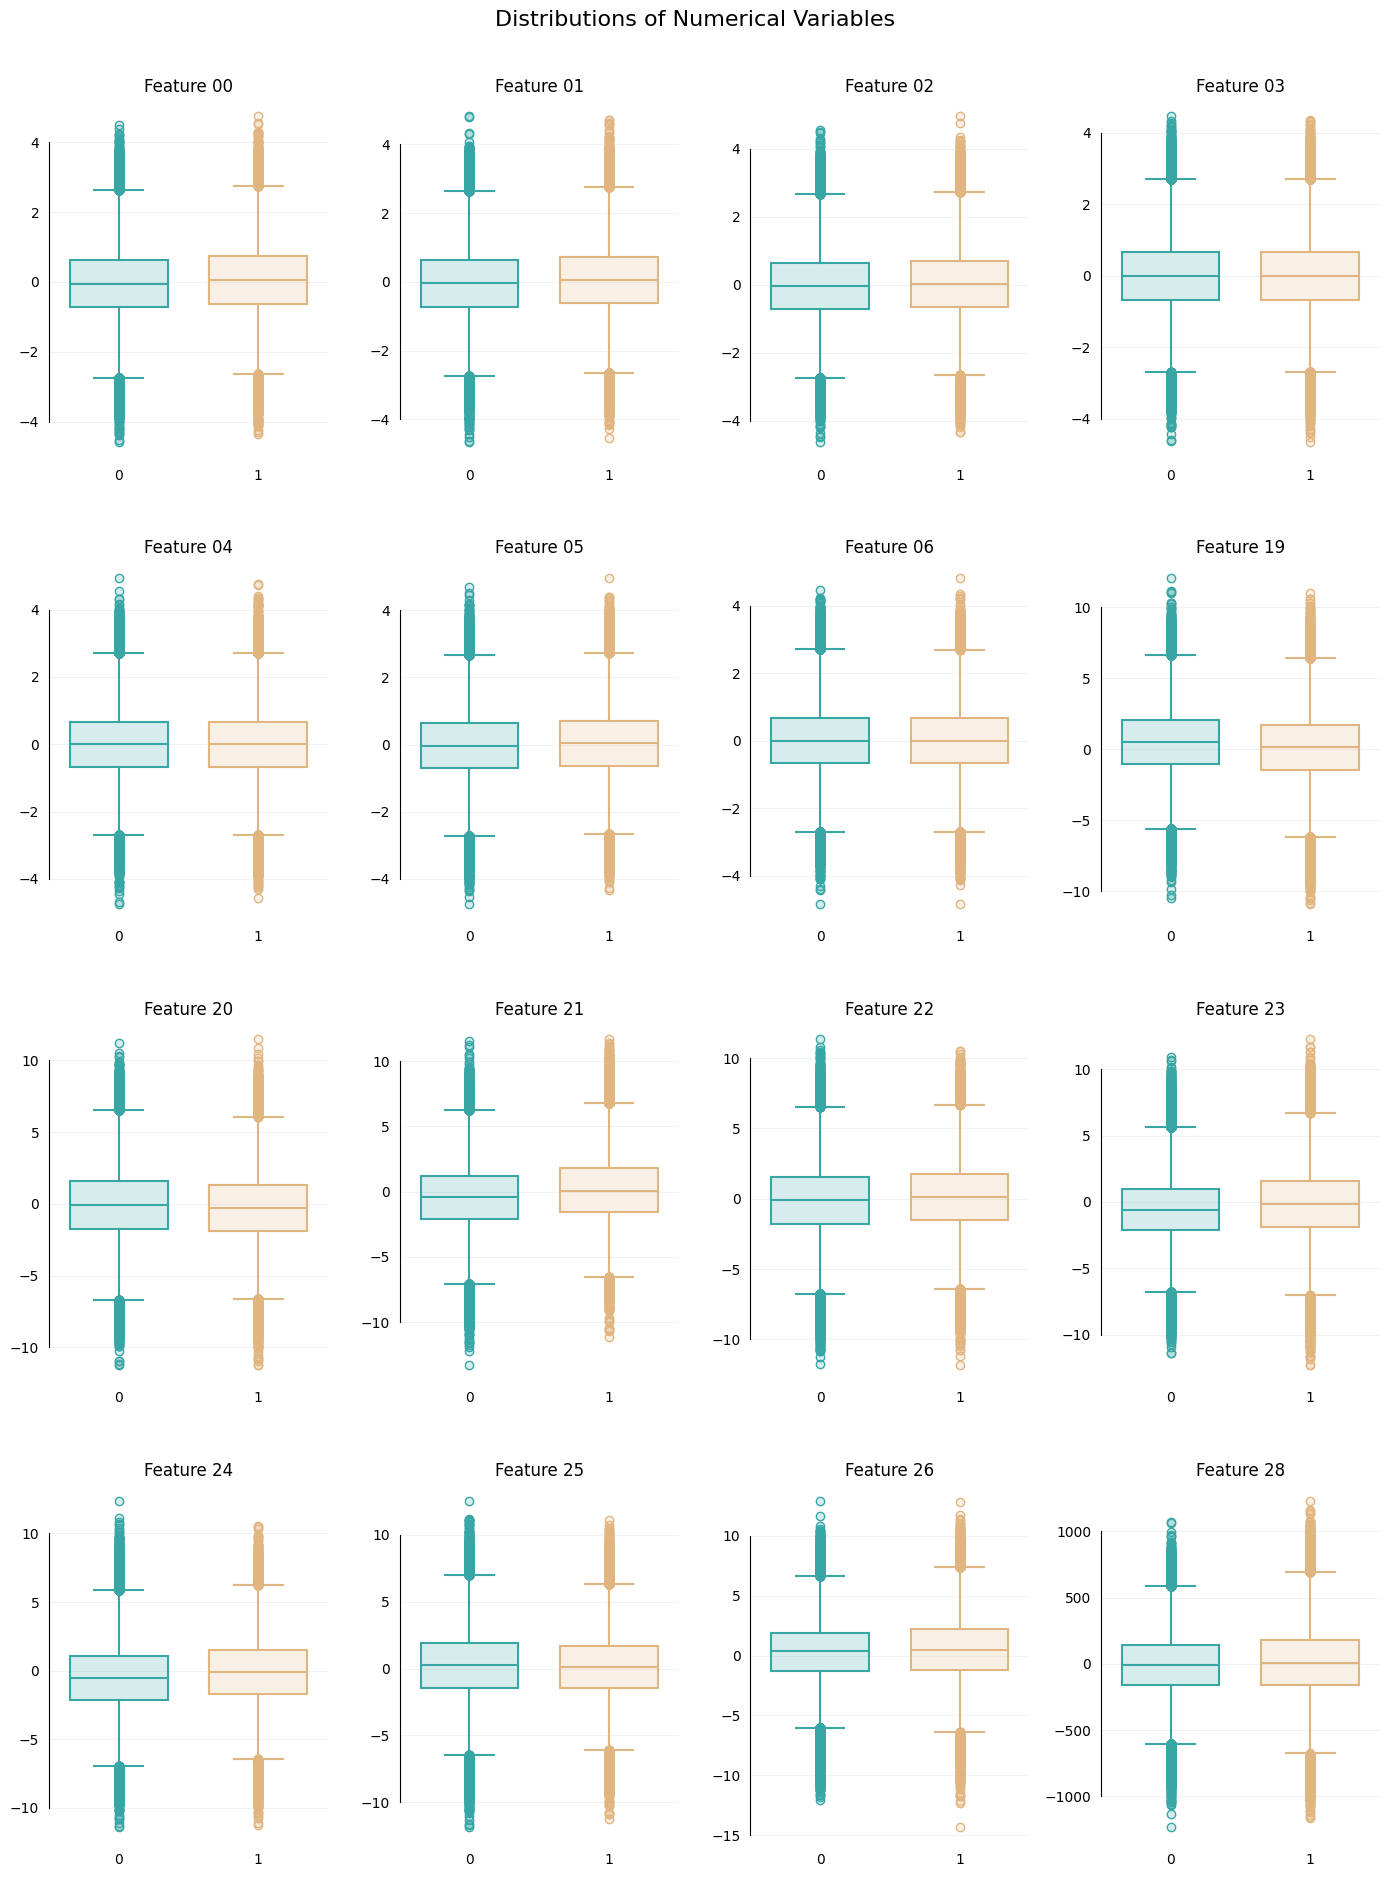

In [4]:
float_cols=train.select_dtypes('float')
df=pd.concat([float_cols,train['target']], axis=1)
titles=['Feature {}'.format(i.split('_')[-1]) for i in df.columns[:-1]]

fig, ax = plt.subplots(4,4, figsize=(14,24))
row=0
col=[0,1,2,3]*4
for i, column in enumerate(df.columns[:-1]):
    if (i!=0) & (i%4==0):
        row+=1
    color='#38A6A5'
    rgb=matplotlib.colors.to_rgba(color,0.2)
    ax[row,col[i]].boxplot(df[df.target==0][column], positions=[0], 
                           widths=0.7, patch_artist=True,
                           boxprops=dict(color=color, facecolor=rgb, linewidth=1.5),
                           capprops=dict(color=color,linewidth=1.5),
                           whiskerprops=dict(color=color,linewidth=1.5),
                           flierprops=dict(markerfacecolor=rgb, markeredgecolor=color),
                           medianprops=dict(color=color,linewidth=1.5))
    color='#E1B580'
    rgb=matplotlib.colors.to_rgba(color,0.2)
    ax[row,col[i]].boxplot(df[df.target==1][column], positions=[1],
                           widths=0.7, patch_artist=True,
                           boxprops=dict(color=color, facecolor=rgb, linewidth=1.5),
                           capprops=dict(color=color, linewidth=1.5),
                           whiskerprops=dict(color=color, linewidth=1.5),
                           flierprops=dict(markerfacecolor=rgb,markeredgecolor=color),
                           medianprops=dict(color=color,linewidth=1.5))
    ax[row,col[i]].grid(visible=True, which='major', axis='y', color='#F2F2F2')
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set_title('\n\n{}'.format(titles[i]))
sns.despine(bottom=True, trim=True)
plt.suptitle('Distributions of Numerical Variables',fontsize=16)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])


In [5]:
float_cols=pd.concat([float_cols,train['target']],axis=1)
fig=make_subplots(rows=4,cols=4,
                  subplot_titles=titles,
                  shared_yaxes=True)
col=[1,2,3,4]*4
row=0
pal=sns.color_palette("GnBu",30).as_hex()[12:]
for i,column in enumerate(float_cols.columns[:-1]):
    if i%4==0:
        row+=1
    float_cols['bins'] = pd.cut(float_cols[column],250)
    float_cols['mean'] = float_cols.bins.apply(lambda x: x.mid)
    df = float_cols.groupby('mean')[column,'target'].transform('mean')
    df = df.drop_duplicates(subset=[column]).sort_values(by=column)
    fig.add_trace(go.Scatter(x=df[column], y=df.target, name=column,
                             marker_color=pal[i],showlegend=False),
                  row=row, col=col[i])
    fig.update_xaxes(zeroline=False, row=row, col=col[i])
    if i%4==0:
        fig.update_yaxes(title='Target Probabilitiy',row=row,col=col[i])
fig.update_layout(template=temp, title='Feature Relationships with Target', 
                  hovermode="x unified",height=1000,width=900)
fig.show()


ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

In [6]:
int_df=train.select_dtypes('int')
sub_titles=['Feature {}'.format(i.split('_')[-1]) for i in int_df.columns[:-1]]

pal=['#38A6A5','#E1B580']
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.6)) for i in pal]

fig = make_subplots(rows=5, cols=3, subplot_titles=sub_titles)
row=0
c=[1,2,3]*5
for i,col in enumerate(int_df.columns[:-1]):
    if i%3==0:
        row+=1
    df=int_df.groupby(col)['target'].value_counts().rename('count').reset_index()
    fig.add_trace(go.Bar(x=df[df.target==0][col], y=df[df.target==0]['count'],width=.3,
                         marker_color=rgb[0], marker_line=dict(color=pal[0],width=2.5),
                         hovertemplate='Value: %{x}Count: %{y}',
                         name='State 0', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    fig.add_trace(go.Bar(x=df[df.target==1][col], y=df[df.target==1]['count'],width=.3,
                         marker_color=rgb[1], marker_line=dict(color=pal[1],width=2.5), 
                         hovertemplate='Value: %{x}Count: %{y}',
                         name='State 1', showlegend=(True if i==0 else False)),
                  row=row, col=c[i])
    if i%3==0:
        fig.update_yaxes(title='Count',row=row,col=c[i])
fig.update_layout(template=temp,title="Distributions of Discrete Variables",
                  legend=dict(orientation="h",yanchor="bottom",y=1.03,xanchor="right",x=.95),
                  barmode='group',height=1500,width=900)
fig.show()


In [7]:
corr=train.corr().round(2)  
corr=corr.iloc[:-1,-1].sort_values(ascending=False)
titles=['Feature '+str(i.split('_')[1]) for i in corr.index]
corr.index=titles
pal=sns.color_palette("RdYlBu",32).as_hex()
pal=[j for i,j in enumerate(pal) if i not in (14,15)]
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.8)) for i in pal] 
fig=go.Figure()
fig.add_trace(go.Bar(x=corr.index, y=corr, marker_color=rgb,
                     marker_line=dict(color=pal,width=2),
                     hovertemplate='%{x} correlation with Target = %{y}',
                     showlegend=False, name=''))
fig.update_layout(template=temp, title='Feature Correlations with Target', 
                  yaxis_title='Correlation', xaxis_tickangle=45, width=800)
fig.show()


ValueError: could not convert string to float: 'ACBADABECB'

In [8]:
corr=train.iloc[:,:-1].corr().round(2)  
mask=np.triu(np.ones_like(corr, dtype=bool))
c_mask = np.where(~mask, corr, 100)
c=[]
for i in c_mask.tolist()[1:]:
    c.append([x for x in i if x != 100])
    
cor=c[::-1]
x=corr.index.tolist()[:-1]
y=corr.columns.tolist()[1:][::-1]
fig=ff.create_annotated_heatmap(z=cor, x=x, y=y,
                                hovertemplate='Correlation between %{x} and %{y}= %{z}',
                                colorscale='emrld', reversescale=True, name='')
fig.update_layout(template=temp, title='Correlations between Features',
                  yaxis=dict(showgrid=False,autorange="reversed"),
                  xaxis=dict(showgrid=False), height=1000,width=1000)
fig.show()


ValueError: could not convert string to float: 'ACBADABECB'

In [9]:
enc = OrdinalEncoder()
def feature_eng(df):
    df=df.copy()
    df['char_unique']=df['f_27'].apply(lambda x: len(set(x)))
    for i in range(df.f_27.str.len().max()):
        df['f_27_char{}'.format(i+1)]=enc.fit_transform(df['f_27'].str.get(i).values.reshape(-1,1))
    return df.drop(['f_27'],axis=1)

train_df=feature_eng(df=train)
test_df=feature_eng(df=test)


In [10]:
char=train['f_27'].value_counts().nlargest(20)
pal=sns.color_palette("Spectral",22).as_hex() 
pal=[j for i,j in enumerate(pal) if i not in (10,11)]
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.75)) for i in pal] 
fig = go.Figure()
fig.add_trace(go.Bar(x=char.index, y=char, marker_color=rgb, 
                     marker_line=dict(color=pal,width=2),
                     showlegend=False))
fig.update_layout(template=temp,title="Most Common Character Strings",
                  yaxis_title="Count", width=800)
fig.show()


In [11]:
df=train[['f_27']]
for letter in string.ascii_uppercase:
    df['{}'.format(letter)]=df['f_27'].str.count(letter)
df_sum=df.iloc[:,1:].sum(axis=0).rename('sum').reset_index()
pal=sns.color_palette("Spectral_r",28).as_hex()
pal=[j for i,j in enumerate(pal) if i !=14]
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.8)) for i in pal] 
fig = go.Figure()
fig.add_trace(go.Bar(x=df_sum['index'], y=df_sum['sum'], marker_color=rgb, 
                     marker_line=dict(color=pal,width=2),
                     showlegend=False))
fig.update_layout(template=temp,title="Most Common Letters",
                  yaxis_title="Count", width=900)
fig.show()


In [12]:
scaler = StandardScaler()
y=train_df['target']
X=train_df.drop(['target'], axis=1)
X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
X_test=pd.DataFrame(scaler.transform(test_df))

y_valid, gbm_val_preds, gbm_test_preds=[],[],[]
cal_true, cal_pred=[],[]
feat_importance=pd.DataFrame(index=X.columns)
k_fold = KFold(n_splits=5, shuffle=True, random_state=21)
for fold, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
    
    print("\nFold {}".format(fold+1))
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]
    print("Train shape: {}, {}, Valid shape: {}, {}".format(
        X_train.shape, y_train.shape, X_val.shape, y_val.shape))
    
    params = {'boosting_type': 'gbdt',
              'n_estimators': 250,
              'num_leaves': 50,
              'learning_rate': 0.1,
              'colsample_bytree': 0.9,
              'subsample': 0.8,
              'reg_alpha': 0.1,
              'objective': 'binary',
              'metric': 'auc',
              'random_state': 21}
    
    gbm = LGBMClassifier(**params).fit(X_train, y_train, 
                                       eval_set=[(X_train, y_train), (X_val, y_val)],
                                       verbose=100,
                                       eval_metric=['binary_logloss','auc'])
    
    gbm_prob = gbm.predict_proba(X_val)[:,1]
    y_valid.append(y_val)
    gbm_val_preds.append(gbm_prob)
    gbm_test_preds.append(gbm.predict_proba(X_test)[:,1])
    feat_importance["Importance_Fold"+str(fold)]=gbm.feature_importances_
    
    calibrated_gbm = CalibratedClassifierCV(base_estimator=gbm, cv="prefit")
    cal_fit = calibrated_gbm.fit(X_train, y_train)
    cal_probs = calibrated_gbm.predict_proba(X_val)[:, 1]
    prob_true, prob_pred = calibration_curve(y_val, cal_probs, n_bins=10)
    cal_true.append(prob_true)
    cal_pred.append(prob_pred)
    auc_score=roc_auc_score(y_val, gbm_prob)
    print("Validation AUC = {:.4f}".format(auc_score))
      
    del X_train, y_train, X_val, y_val
    gc.collect()  



Fold 1
Train shape: (640000, 41), (640000,), Valid shape: (160000, 41), (160000,)


TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'verbose'

In [13]:
colors=px.colors.qualitative.Prism
def plot_roc_calibration(y_val, y_prob, mpv_cal, fop_cal):
    fig=go.Figure()
    fig.add_trace(go.Scatter(x=np.linspace(0,1,11), y=np.linspace(0,1,11), 
                             name='Random Chance',mode='lines',
                             line=dict(color="Black", width=1, dash="dot")))
    for i in range(len(y_val)):
        y=y_val[i]
        prob=y_prob[i]
        fpr, tpr, thresh = roc_curve(y, prob)
        roc_auc = auc(fpr,tpr)
        fig.add_trace(go.Scatter(x=fpr, y=tpr, line=dict(color=colors[::-1][i+6], width=3), 
                                 hovertemplate = 'True positive rate = %{y:.3f}, False positive rate = %{x:.3f}',
                                 name='Fold {} AUC = {:.4f}'.format(i+1,roc_auc)))
    fig.update_layout(template=temp, title="Cross-Validation ROC Curves", 
                      hovermode="x unified", width=600,height=500,
                      xaxis_title='False Positive Rate (1 - Specificity)',
                      yaxis_title='True Positive Rate (Sensitivity)',
                      legend=dict(orientation='v', y=.07, x=1, xanchor="right",
                                  bordercolor="black", borderwidth=.5))
    fig.show()
    fig=go.Figure()
    fig.add_trace(go.Scatter(x=np.linspace(0,1,11), y=np.linspace(0,1,11), 
                             name='Perfectly Calibrated',mode='lines',
                             line=dict(color="Black", width=1, dash="dot"),legendgroup=2))
    for i in range(len(mpv_cal)):
        mpv=mpv_cal[i]
        fop=fop_cal[i]
        fig.add_trace(go.Scatter(x=mpv, y=fop, line=dict(color=colors[::-1][i+6], width=3), 
                                 hovertemplate = 'Proportion of Positives = %{y:.3f}, Mean Predicted Probability = %{x:.3f}',
                                 name='Fold {}'.format(i+1),legendgroup=2))
    fig.update_layout(template=temp, title="Probability Calibration Curves", 
                      hovermode="x unified", width=600,height=500,
                      xaxis_title='Mean Predicted Probability',
                      yaxis_title='Proportion of Positives',
                      legend=dict(orientation='v', y=.07, x=1, xanchor="right",
                                  bordercolor="black", borderwidth=.5))
    fig.show()
    
def plot_target_predictions(df):
    plot_df=pd.DataFrame.from_dict({'1':(len(df[df.target>0.5])/len(df.target))*100, 
                                    '0':(len(df[df.target0.5])/len(df.target))*100}, 
                                   orient='index', columns=['pct'])
    text=['State {}'.format(i) for i in plot_df.index]
    color,pal=['#38A6A5','#E1B580'],['#88CAC9','#EDD3B3']
    if text[0]=='State 0':
        color,pal=color,pal
    else:
        color,pal=color[::-1],pal[::-1]
    fig=go.Figure()
    fig.add_trace(go.Pie(labels=plot_df.index, values=plot_df.pct, hole=.5, 
                         text=text, sort=False, showlegend=False,
                         marker=dict(colors=pal,line=dict(color=color,width=2)),
                         hovertemplate = "State %{label}: %{value:.2f}%"))
    fig.update_layout(template=temp, title='Predicted Target Distribution', width=400,
                      uniformtext_minsize=15, uniformtext_mode='hide')
    fig.show()
    
plot_roc_calibration(y_valid, gbm_val_preds, cal_true, cal_pred)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2625595331.py, line 42)

In [14]:
feat_importance['avg']=feat_importance.mean(axis=1)
feat_importance=feat_importance.sort_values(by='avg',ascending=True)

pal=sns.color_palette("YlGnBu", 52).as_hex()
fig=go.Figure()
for i in range(len(feat_importance.index)):
    fig.add_shape(dict(type="line", y0=i, y1=i, x0=0, x1=feat_importance['avg'][i], 
                       line_color=pal[::-1][i],opacity=0.8,line_width=4))
fig.add_trace(go.Scatter(x=feat_importance['avg'], y=feat_importance.index, mode='markers', 
                         marker_color=pal[::-1], marker_size=8,
                         hovertemplate='%{y} Importance = %{x:.0f}'))
fig.update_layout(template=temp,title='Feature Importance', 
                  xaxis=dict(title='Average Importance',zeroline=False),
                  yaxis_showgrid=False, height=900, width=800)
fig.show()


In [15]:
sub_gbm=sub.copy()
sub_gbm['target']=np.mean(gbm_test_preds, axis=0)
sub_gbm.to_csv("sub_gbm.csv", index=False)
plot_target_predictions(sub_gbm)


NameError: name 'plot_target_predictions' is not defined

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, InputLayer, Add
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import metrics, regularizers
from tensorflow.keras.utils import plot_model

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


2025-08-18 21:53:54.585373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755554034.595800       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755554034.598867       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 21:53:54.613754: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Please provide a TPU Name to connect to.

In [17]:
def nn_model():
    
    x_input = Input(shape=(train_df.shape[1]-1))
    x = Dense(512, kernel_regularizer=regularizers.l2(1e-5),
              activation='swish')(x_input)
    x = Dense(384, kernel_regularizer=regularizers.l2(1e-5),
              activation='swish')(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(1e-5),
              activation='swish')(x)
    x = Dense(128, kernel_regularizer=regularizers.l2(1e-5),
              activation='swish')(x)
    x = Dense(64, kernel_regularizer=regularizers.l2(1e-5),
              activation='swish')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=x_input, outputs=output)
    
    return model

model = nn_model()
plot_model(model, show_layer_names=False, show_shapes=True)


ValueError: Cannot convert '41' to a shape.

In [18]:
y=train_df['target']
X=train_df.drop(['target'], axis=1)
X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
X_test=pd.DataFrame(scaler.transform(test_df))

y_valid, nn_val_preds, nn_test_preds=[],[],[]
cal_true, cal_pred=[],[]
k_fold = KFold(n_splits=5, shuffle=True, random_state=21)

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

for fold, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
    
    print("\n*****Fold {}*****".format(fold+1))
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]
    print("Train shape: {}, {}, Valid shape: {}, {}".format(
        X_train.shape, y_train.shape, X_val.shape, y_val.shape))
    
    with tpu_strategy.scope():

        model = nn_model()
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=[metrics.AUC(name = 'auc')])
        
        lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5,  patience=3, verbose=True)
        es = EarlyStopping(monitor='val_auc', mode='max', patience=5, 
                           restore_best_weights=True, verbose=True)
        
        model.fit(X_train, y_train,
                  validation_data=(X_val, y_val), 
                  epochs=10, batch_size=4096, 
                  callbacks=[es,lr], verbose=True, shuffle=True)
        
        nn_preds = model.predict(X_val).squeeze()
        y_valid.append(y_val)
        nn_val_preds.append(nn_preds)
        nn_test_preds.append(model.predict(X_test).squeeze())
        
        prob_true, prob_pred = calibration_curve(y_val, nn_preds, n_bins=10)
        cal_true.append(prob_true)
        cal_pred.append(prob_pred)
      
    del X_train, y_train, X_val, y_val
    gc.collect()  



*****Fold 1*****
Train shape: (640000, 41), (640000,), Valid shape: (160000, 41), (160000,)


NameError: name 'tpu_strategy' is not defined

In [19]:
plot_roc_calibration(y_valid, nn_val_preds, cal_true, cal_pred)


NameError: name 'plot_roc_calibration' is not defined